In [1]:
from utils_int import *
from defines_int import *

import numpy as np
import pandas as pd

from collections import Counter

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, StratifiedKFold
import re

import pathlib


from sklearn.datasets import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG


# import lime
import lime
import lime.lime_tabular

#pickle
import pickle

#import shap
import shap

In [2]:
# data from variable guide
data_varaible_cat = {}
with open("data_varaible_cat.pkl", "rb") as f:
    data_varaible_cat = pickle.load(f)

len(data_varaible_cat)

911

In [3]:
print (orginal_data_path)

../../../data_off/optima/dementia_data/


In [4]:
data = pd.read_pickle(orginal_data_path+'Optima_Data_Report_Cases_9584_filled_pickle')

In [5]:
data.shape

(9584, 1593)

In [6]:
len(attributes_considered)

210

In [7]:
attributes_considered += george_labels_one_years
attributes_considered += george_labels_three_years
attributes_considered = list(set(attributes_considered))
len(attributes_considered)

242

In [8]:
all_dementia = [['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', [2, 3, 4]],
           ['DIAGNOSIS 334-351: DEMENTIA   CLOUDED', [1]],
           ['DIAGNOSIS 334-351: CLOUDED   DEMENTIA', [1]],
           ['DIAGNOSIS 334-351: SEVERITY OF DEMENTIA', [2, 3, 4]],
           ["OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT", [1, 2, 3]],
           ["OPTIMA DIAGNOSES V 2010: MIXED DEMENTIA", [1]],
           ["GENERAL INFORMATION: SPET SCORE", [6]],
           ["GENERAL INFORMATION: DSM-IIIR", [1]],
           ["GENERAL INFORMATION: CLINICAL DIAGNOSIS 1", [1]]]

In [9]:
no_dementia = [['CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', [0]],
           ['DIAGNOSIS 334-351: SEVERITY OF DEMENTIA', [0]],
           ["OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT", [0]],
           ["GENERAL INFORMATION: DSM-IIIR", [0]],
           ["GENERAL INFORMATION: CLINICAL DIAGNOSIS 1", [0]]]

In [10]:
all_dem = set()
for i, j in all_dementia:
    all_dem |= extract_values(data, i, j)[0]

1827 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA
10 DIAGNOSIS 334-351: DEMENTIA   CLOUDED
2 DIAGNOSIS 334-351: CLOUDED   DEMENTIA
613 DIAGNOSIS 334-351: SEVERITY OF DEMENTIA
951 OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT
172 OPTIMA DIAGNOSES V 2010: MIXED DEMENTIA
0 GENERAL INFORMATION: SPET SCORE
1 GENERAL INFORMATION: DSM-IIIR
876 GENERAL INFORMATION: CLINICAL DIAGNOSIS 1


In [11]:
no_dem = set()
for i, j in no_dementia:
    no_dem |= extract_values(data, i, j)[0]

2084 CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA
985 DIAGNOSIS 334-351: SEVERITY OF DEMENTIA
2185 OPTIMA DIAGNOSES V 2010: DEMENTIA PRESENT
1 GENERAL INFORMATION: DSM-IIIR
965 GENERAL INFORMATION: CLINICAL DIAGNOSIS 1


In [12]:
len(no_dem), len(all_dem)

(3647, 2979)

In [13]:
no_dem -= all_dem

In [14]:
len(no_dem), len(all_dem)

(3402, 2979)

In [15]:
dem_patients = set(data.loc[all_dem].GLOBAL_PATIENT_DB_ID.unique())
no_dem_patients = set(data.loc[no_dem].GLOBAL_PATIENT_DB_ID.unique())
print(len(dem_patients.intersection(no_dem_patients)))
no_dem_patients -= dem_patients

176


In [16]:
data_no_dem = data.loc[no_dem]
data_no_dem = data_no_dem[data_no_dem['GLOBAL_PATIENT_DB_ID'].isin(no_dem_patients)]
data_no_dem['dementia_range'] = 0

In [17]:
data_dem = data.loc[all_dem]
data_dem['dementia_range'] = 1

In [18]:
data_no_dem.shape, data_dem.shape

((2616, 1594), (2979, 1594))

In [19]:
prepared_dataset = pd.concat([data_dem, data_no_dem])[attributes_considered]

In [20]:
## Prepared dataset without any modification
prepared_dataset_org = prepared_dataset

In [21]:
for i, j in zip(prepared_dataset, prepared_dataset.dtypes):
    if not (j == "float64" or j == "int64"):
        print(i)
        prepared_dataset[i] = pd.to_numeric(prepared_dataset[i], errors='coerce')

DIAGNOSIS 334-351: DEPRESSIVE ILLNESS
DIAGNOSIS 334-351: SEVERITY OF DEPRESSION
GENDER
COGNITIVE EXAM 120-161: (160) SUBTRACTING SEVENS
PRESENT STATE 13-46: (018) LIVING ARRANGEMENTS
DIAGNOSIS 334-351: ANXIETY/PHOBIC
COGNITIVE EXAM 120-161: (147) RECOGNISES PICTURES
COGNITIVE EXAM 162-187: ACTUAL DURATION OF INTERVIEW


In [22]:
# drop irrelavent columns
# prepared_dataset = prepared_dataset.drop(columns=score_columns)
prepared_dataset = prepared_dataset.replace([-1], [np.nan])

In [23]:
prepared_dataset.shape

(5595, 242)

In [24]:
# drop rows with maximum number of missing values
prepared_dataset_tmp = prepared_dataset[prepared_dataset.isna().sum(axis=1)<70]

In [25]:
prepared_dataset_tmp = drop_missing_columns(prepared_dataset_tmp, 0.80)

Before dataset.shape (3030, 242)
After dataset.shape (3030, 178)


In [26]:
prepared_dataset = prepared_dataset_tmp

In [27]:
currupt_categorical_columns = ['COGNITIVE EXAM 120-161: (158) REGISTERS OBJECTS', 'COGNITIVE EXAM 120-161: (137) IDENTIFIES OBJECTS',]
confused_categorical_columns = ['COGNITIVE EXAM 162-187: (174) MIME - BRUSHING TEETH']                               
categorical_columns = [col for col in prepared_dataset.columns if col in data_varaible_cat.keys()]
categorical_columns_final = list(set(categorical_columns)-set(currupt_categorical_columns)-set(confused_categorical_columns))
drop_columns = ['DIAGNOSIS 334-351: DEPRESSIVE ILLNESS_0.0',
               ]

In [28]:
for column in categorical_columns_final:
    def replace_numerical_category(column, x):
        if x in data_varaible_cat[column]:
            x = data_varaible_cat[column][x]
        else:
            x = np.nan
        return x
    prepared_dataset[column]=prepared_dataset[column].apply(lambda x : replace_numerical_category(column, x))

In [29]:
prepared_dataset[categorical_columns_final] = prepared_dataset[categorical_columns_final].replace([np.nan], ['Unknown'])

In [30]:
def find_mixed_type_list(l):
    for i in range(0,len(l)-1):
        if type(l[i])!=type(l[i+1]):
            return True
    return False
        
list_corrupted_columns = []        
for col in categorical_columns:
    if find_mixed_type_list(prepared_dataset[col].unique().tolist()):
        list_corrupted_columns.append(col)
        print (col,': ',prepared_dataset[col].unique().tolist())

print(len(list_corrupted_columns))

0


In [31]:
for col in list_corrupted_columns:
    print (prepared_dataset.groupby(col)[col].count())

In [32]:
# replace notasked and doesnot know values
# prepared_dataset[categorical_columns] = prepared_dataset[categorical_columns].replace([8, 9], [np.nan, np.nan])

In [33]:
prepared_dataset.shape

(3030, 178)

In [34]:
# drop missing values
prepared_dataset_exp = drop_missing_columns(prepared_dataset, 0.80)
prepared_dataset_exp.shape

Before dataset.shape (3030, 178)
After dataset.shape (3030, 178)


(3030, 178)

In [35]:
# if drop score columns
prepared_dataset = prepared_dataset[prepared_dataset['CAMDEX SCORES: MINI MENTAL SCORE']>=0]

In [36]:
prepared_dataset.shape

(3028, 178)

In [37]:
# feature transforamtion - one-hot encoding

prepared_dataset_exp = prepared_dataset

new_prepared_data = prepared_dataset_exp.drop(categorical_columns_final, axis=1)
for i in categorical_columns_final:
    x = pd.get_dummies(prepared_dataset_exp[i]).add_prefix(i+'::')
    new_prepared_data = pd.concat([new_prepared_data, x], axis=1)
    
new_prepared_data['dementia_range'] = prepared_dataset_exp['dementia_range']

prepared_dataset_exp = new_prepared_data

In [38]:
prepared_dataset_exp.shape

(3028, 577)

In [39]:
prepared_dataset_exp = prepared_dataset_exp.drop(columns=[col for col in prepared_dataset_exp.columns if '::Unknown' in col])
prepared_dataset_exp.shape

(3028, 512)

In [40]:
prepared_dataset_exp = prepared_dataset_exp.dropna()
prepared_dataset_exp.shape

(2126, 512)

In [41]:
# training data
X_full, y_full = prepared_dataset_exp.drop(columns=['dementia_range']), prepared_dataset_exp['dementia_range']

In [42]:

# impute missing values
"""knn_estimator = KNeighborsRegressor(n_neighbors=15)
imputer = IterativeImputer(random_state=0, estimator=knn_estimator)
X_full_imput = imputer.fit_transform(X_full)
y_full_imput = y_full.values"""

'knn_estimator = KNeighborsRegressor(n_neighbors=15)\nimputer = IterativeImputer(random_state=0, estimator=knn_estimator)\nX_full_imput = imputer.fit_transform(X_full)\ny_full_imput = y_full.values'

In [43]:
X_full_imput, y_full_imput = X_full.values, y_full.values

# model training
def change_feature_names(feature_name):
    p1 = '\w.*\d.*-\d.*:\s\(\d.*\w\)\s'
    p2 = '\w.*:\s'
    feature_name = re.sub(p1, '', feature_name)
    #feature_name = re.sub(p2, '', feature_name)
    for key, value in score_dict.items():
        if feature_name in key:
            feature_name = feature_name+'{}'.format(value)
    return feature_name


rf_estimator = RandomForestClassifier(max_depth=5, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=123)
important_features = set()
important_features_size = 50
for i, (train, test) in enumerate(cv.split(X_full_imput, y_full_imput)):
    rf_estimator.fit(X_full_imput[train], y_full_imput[train])
    y_predicted = rf_estimator.predict(X_full_imput[test])
    print (classification_report(y_full_imput[test], y_predicted))
    
    # print important features
    # model important feature
    fea_importance = rf_estimator.feature_importances_
    indices = np.argsort(fea_importance)[::-1]
    for f in range(important_features_size):
        # print("%d. feature: %s (%f)" % (f + 1, X_full.columns.values[indices[f]], fea_importance[indices[f]]))
        important_features.add(X_full.columns.values[indices[f]])
    #lime interpretability 
    '''explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_full_imput[train]), 
                                                       feature_names=[change_feature_names(fea) for fea in X_full.columns.values], 
                                                       class_names=rf_estimator.classes_, discretize_continuous=True, random_state=123)
    exp = explainer.explain_instance(X_full_imput[test][5], rf_estimator.predict_proba, num_features=20)
    exp.show_in_notebook(show_table=True, show_all=False)'''
    #print (exp.as_list())
    #fig = exp.as_pyplot_figure()
    #plt.show()
    
    # shap interpretability
    
#important feature list
print ('important_features: ', list(important_features))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       340
           1       0.96      0.90      0.93       298

    accuracy                           0.94       638
   macro avg       0.94      0.94      0.94       638
weighted avg       0.94      0.94      0.94       638

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       340
           1       0.96      0.92      0.94       298

    accuracy                           0.95       638
   macro avg       0.95      0.95      0.95       638
weighted avg       0.95      0.95      0.95       638

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       340
           1       0.97      0.93      0.95       298

    accuracy                           0.95       638
   macro avg       0.95      0.95      0.95       638
weighted avg       0.95      0.95      0.95       638

              preci

In [44]:
prepared_dataset_exp_full = prepared_dataset_exp

#Taking important features
prepared_dataset_exp = prepared_dataset_exp[list(important_features)+['dementia_range']]

X_train, X_test, y_train, y_test = train_test_split(prepared_dataset_exp.drop(columns=['dementia_range']).values, prepared_dataset_exp['dementia_range'].values, test_size=0.3, random_state=42, stratify=prepared_dataset_exp['dementia_range'])

# First Glance Results

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       340
           1       0.91      0.92      0.91       298

    accuracy                           0.92       638
   macro avg       0.92      0.92      0.92       638
weighted avg       0.92      0.92      0.92       638



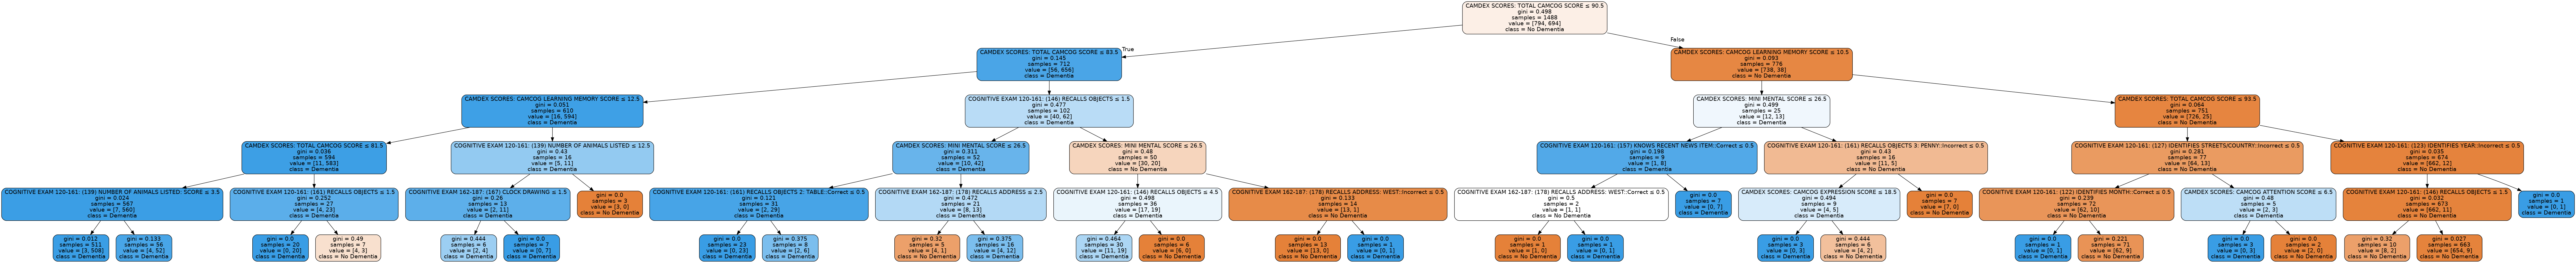

In [45]:
import graphviz
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus, joblib
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

feature_names = prepared_dataset_exp.drop(columns=['dementia_range']).columns

clf = tree.DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train, y_train) 
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print (classification_report(y_test, y_pred))

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_names, 
               class_names=['No Dementia', 'Dementia'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [46]:
def change_feature_names(feature_name):
    p1 = '\w.*\d.*-\d.*:\s\(\d.*\w\)\s'
    p2 = '\w.*:\s'
    feature_name = re.sub(p1, '', feature_name)
    # feature_name = re.sub(p2, '', feature_name)
    for key, value in score_dict.items():
        if feature_name in key:
            feature_name = feature_name+'{}'.format(value)
    return feature_name
    


bool_feature_names_DT = prepared_dataset_exp.select_dtypes(include='uint8').columns
feature_names_DT = [change_feature_names(i) for i in feature_names]
bool_feature_names_DT = [change_feature_names(i) for i in  bool_feature_names_DT] # Important 0: NO and 1: YES
bool_feature_names_true_DT = [i for i in bool_feature_names_DT if '::' in i] #('IDENTIFIES' in i or 'RECALL' in i) and '_1.0' in i ]
bool_feature_names_false_DT = [i for i in bool_feature_names_DT if '::' in i] #('IDENTIFIES' in i or 'RECALL' in i) and '_0.0' in i ]
feature_names_for_split_DT = [i for i in feature_names_DT if ' SCORE' in i] 


viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='class',
               feature_names=feature_names_DT,
               bool_feature_names_true=bool_feature_names_true_DT,
               bool_feature_names_false=bool_feature_names_false_DT,
               feature_names_for_split=feature_names_for_split_DT,
               class_names=['No Dementia', 'Dementia'],
               fancy=False, label_fontsize=40, ticks_fontsize=2)

viz.save('model_1DT_score_all.svg')
drawing = svg2rlg("./model_1DT_score_all.svg".format(i))
renderPDF.drawToFile(drawing, "./model_1DT_score_all.pdf".format(i))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
